# Comparison of MFA and simulation results of the majority rule model

The code below implements the majority rule cellular automaton, as well as the mean-field approximation derived in Sayama.

**Tasks:**

* **Briefly review the code**
 * You have seen this before in class but might want to look through the `update()` method of the simulation and the mean-field approximation function below to refresh your memory.
 * The `majority_mfa()` function is more interesting to review since it generalizes the mean-field approximation derived in Sayama (page 217) from a radius of 1 (a 3 × 3 neighborhood) to any radius.
* **Questions**
 * For which initial density and radius parameters does the MFA work well?
 * Why does the MFA match the simulation results nearly perfectly after 1 step but not so well after 2 or more steps?

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
class MajoritySimulator:

    def __init__(self, size=100, initial_density=0.1, radius=1):
        '''
        Initialize new MajoritySimulator object with default parameter settings.

        Inputs:

            size (int) The number of cells along each dimension of the 2-d
              grid. Default: 100.

            initial_density (float) The proportion of cells that will be active
              (1) when the cellular automaton is initialized. The active cells
              will be at random locations. Default: 0.1.

            radius (int) The radius of the neighborhoods in the CA. Must be a
              positive integer. Default: 1.
        '''
        self.size = size
        self.radius = radius
        self.initial_density = initial_density

        # Set up a random initial state where the fraction of 1s in the array
        # equals the density parameter.
        self.state = np.zeros((size, size))
        random_indexes = np.random.choice(
            range(self.size ** 2),
            size=int(round(self.initial_density * self.size ** 2)),
            replace=False)
        self.state.fill(0)
        self.state.flat[random_indexes] = 1

    def draw(self):
        '''
        Draw the current state of the cellular automaton.
        '''
        plt.figure()  # Create a new figure
        plt.imshow(self.state, vmin = 0, vmax = 1, cmap = plt.cm.binary)
        plt.title(f'State at step {self.step_counter}')
        plt.show()

    def update(self):
        '''
        Update the state of the cellular automaton.
        '''
        total = np.zeros(self.state.shape)
        for dx in range(-self.radius, self.radius+1):
            shifted_state = np.roll(self.state, shift=dx, axis=1)
            for dy in range(-self.radius, self.radius+1):
                total += np.roll(shifted_state, shift=dy, axis=0)
        cells_in_neighborhood = (2 * self.radius + 1) ** 2
        majority_threshold = cells_in_neighborhood // 2 + 1
        self.state = total // majority_threshold

In [3]:
def majority_mfa(density, radius):
    '''
    This is a generalization of the mean-field approximation in Sayama. This
    function works for any neighborhood radius by using the probability mass
    function (pmf) and cumulative distribution function (cdf) of the binomial
    distribution to simplify calculations.
    
    The function returns the next density (probability) of 1s given the current
    density and the radius of the neighborhood.
    '''
    neighbors = (2*radius + 1)**2 - 1
    return (
        (1 - sts.binom.cdf(neighbors//2, n=neighbors, p=density)) +
        density * sts.binom.pmf(neighbors//2, n=neighbors, p=density))

## Comparison

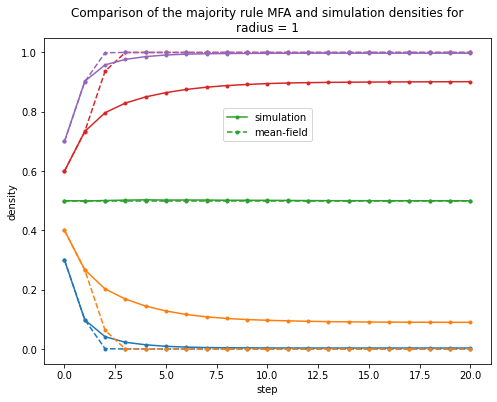

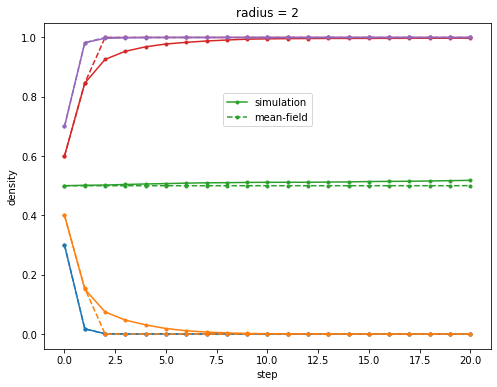

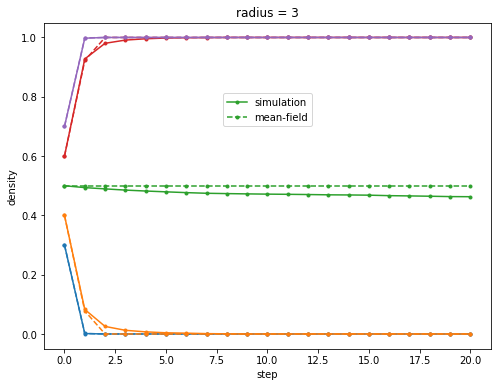

In [4]:
'''
Compute and plot the evolution of the density of 1s according to the simulation
and the MFA.
'''
for radius in [1, 2, 3]:
    
    plt.figure(figsize=(8, 6))
    if radius == 1:
        plt.title(
            'Comparison of the majority rule MFA and simulation densities for\n'
            'radius = 1')
    else:
        plt.title(f'radius = {radius}')
    plt.xlabel("step")
    plt.ylabel("density")

    for initial_density in np.linspace(0.3, 0.7, 5):
        sim = MajoritySimulator(
            initial_density=initial_density, size=200, radius=radius)

        sim_densities = [np.mean(sim.state)]
        mfa_densities = [sim_densities[0]]
        for step in range(20):
            sim.update()
            sim_densities.append(np.mean(sim.state))
            mfa_densities.append(majority_mfa(mfa_densities[-1], radius))

        line1 = plt.plot(sim_densities, marker='.', linestyle='-')
        color = line1[0].get_color()
        line2 = plt.plot(mfa_densities, color=color, marker='.', linestyle="--")    
        if abs(initial_density-0.5) < 1e-3:
            line1[0].set_label('simulation')
            line2[0].set_label('mean-field')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.667))

plt.show()